In [1]:
from defs import *
%config InlineBackend.figure_format = 'retina'

### Plot cross-temporal accuracy for leave-one-trial-out decoding

99.9 loto_ 20190903_N242_H2_rw3_mw[20, 0.1]-.001


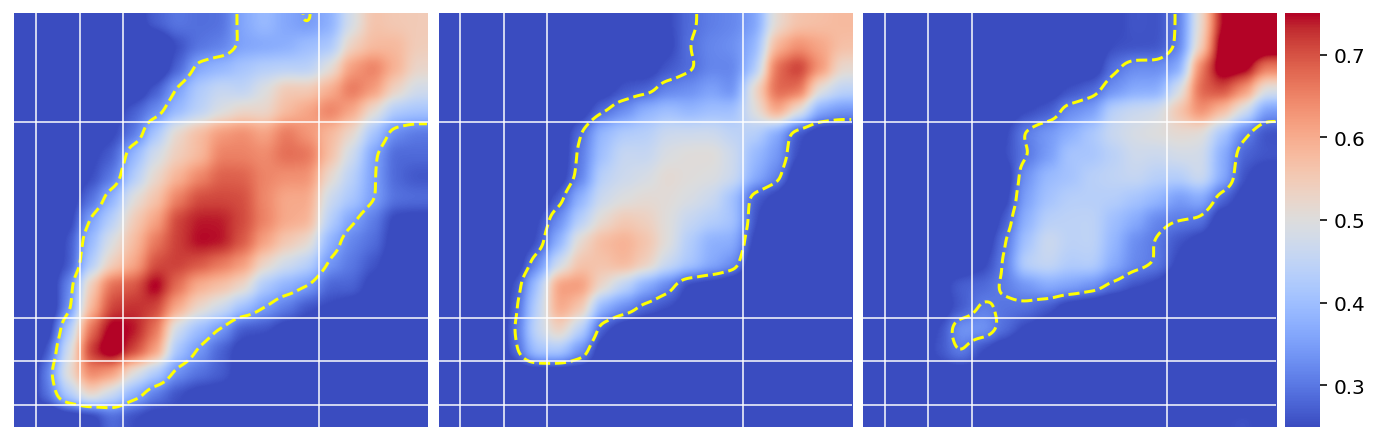

In [5]:
datadate = '20190903'; method = 'loto_' # 'loso_'
sl = 3; pl = 6

filepath = '/mnt/sdb1/TwoPhoton/' +datadate+ '/'
data = sio.loadmat('/mnt/sdb1/mats/more_' + datadate + '.mat'); fr = data['fr'].item()
align1, _, tgs, _, mah, fid = getMarkers(fr, sl, pl, data)
Tt = tgs[mah==1]-1; _, l = getDts(fid, sl, fr, 0)
nTs = np.ones(len(Tt)); vmax = 0.75; npct = 99.9

if 'loso' in method: 
    seq_pool = np.array(list(multiset_permutations(range(pl))))[::np.prod(range(1,pl-sl+1)),:sl]
    nT = np.array([sum((Tt==seq).all(axis=1)) for seq in seq_pool]) 
    Tt = Tt[(Tt[:,0]*36+Tt[:,1]*6+Tt[:,-1]).argsort()]; nTs = nT[nT>0];    
    vmax -= .1; npct -= 0.4 
iTs = np.insert(np.cumsum(nTs),0,0).astype(int)

# load results obtained by runing decode-items.py
Ts = np.load(filepath + method + 'Ts'+str(sl)+'.npy') # ndts, ndts, nTrail, ng, nw, sl
tgCs = np.load(filepath + method + 'tgCs'+str(sl)+'.npy') # nSeq/nTrial, ndts, ndts, sl, pl
lstring = np.load(filepath + method + 'lstring'+str(sl)+'.npy')
print(npct, method, lstring)

Shfs =[] # get shufffle distribution
tgc0 = getTrialWeight(Tt,pl,3)[0]
for rank in range(sl):
    tgcs = tgCs[:,:,:,rank] # item distribution for dummy decoder
    shf = Shuffle(Tt[:,rank], tgcs, iTs, 0, 1000)
    Shfs.append(shf.runShuffle(50)) # total shuffle: 50*1000

Accs = (Ts == Tt.reshape(1,1,-1,1,1,sl)).mean(-2).mean(-2).mean(-2)
Accs = [Accs[:,:,i] for i in range(sl)]
Cont = [Accs[i] - np.percentile(Shfs[i], npct) for i in range(sl)]
pDecode(Accs, Cont, [0.25, vmax], [.3, .4, .5, .6, .7], l[:-1], l[:-1], 20, sl) 

### Calculate macro-F1 score for late delay decoding

In [7]:
MF1s=[]
for rank in range(sl):
    F1 = []; Ts_ = Ts[:,:,:,:,:,rank] 
    for i in range(pl):
        idxt = Tt[:,rank]==i; tgc = sum(idxt)
        tgp = (Ts_==i).mean(-1).mean(-1).sum(-1)
        nc = (Ts_[:,:,idxt]==i).mean(-1).mean(-1).sum(-1)
        if tgc>0: F1.append(2*nc/(tgc+tgp))
    MF1s.append(np.mean(np.stack(F1), 0))
Accs = np.stack(MF1s, -1)
ilooks = [10,11,12,13] if sl==3 else [8,9,10,11]

Sig1=[]; Sig2=[]; Accp=[]
for rank in range(sl):
    tgcs = tgCs[:,np.array(ilooks).reshape(-1,1),ilooks, rank]
    shf = Shuffle(Tt[:,rank], tgcs, iTs, 1, 1000)
    shfs = shf.runShuffle(50) 
    acc = np.mean(Accs[ilooks,ilooks,rank]); Accp.append(acc)
    Sig1.append(acc> np.percentile(shfs, 99))
    Sig2.append(acc> np.percentile(shfs, 99.9))
print(np.round(Accp,3)) # MF1 score
print((np.array(Sig1)+0)+np.array(Sig2)) # degree of significance

[0.528 0.477 0.451]
[2 2 2]
